In [1]:
"""
Script for parsing logs
"""

import os
import sys
sys.path.append(os.path.abspath('../utility'))

import yaml
import json
import pprint
import tabulate
import humanize
import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.interpolate import interp1d

import seaborn as sb
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from const import *
from collections import OrderedDict

## Seaborn aesthetics
sb.set_context(
    "talk",
    font_scale=1,
    rc={
        "lines.linewidth": 1,
        "text.usetex": True,
        "font.family": 'serif',
        "font.serif": 'Palatino',
        "font.size": 16
    })
sb.set_style("whitegrid")

stats = {}
link_stats = {}
cloud_stats = {}
latency = None

In [2]:
"""
Non-Cloud Simulation logs
"""

log_path = "../logs/march"
# log_path += "20190316-2030" ## Two Child - Wait Policy (60 seconds)
# log_path += "20190316-2029" ## Three Child - Wait Policy (60 seconds)

# log_path += "20190316-2244" ## Two Child - Wait Policy (120 seconds)
# log_path += "20190316-2243" ## Three Child - Wait Policy (120 seconds)

# log_path += "20190316-2316" ## Two Child - Simple Policy
# log_path += "20190316-2317" ## Three Child - Simple Policy

# log_path += "20190317-0013" ## Two Child - Time Policy
# log_path += "20190317-0011" ## Three Child - Time Policy

# log_path += "20190317-0058" ## Two Child - Accuracy Policy
# log_path += "20190317-0059" ## Three Child - Accuracy Policy

# log_path += "20190317-1544-five-child-simple" ## Five Child - Simple
# log_path += "20190317-1545-seven-child-simple" ## Seven Child - Simple

# log_path += "20190317-1625-1-2-4-simple"
# log_path += "20190317-1802-1-2-4-simple"

# log_path += "20190319-2032-1-2-4-simple/"
# log_path += "20190319-2035-seven-child-simple/"
# log_path += "20190319-2259-five-child-simple/"
# log_path += "20190319-2251-seven-child-simple/"
# log_path += "20190320-0130-five-child-simple"
# log_path += "20190320-0133-five-child-simple-1"



In [3]:
"""
Cloud Simulation logs
"""

log_path = "../logs/"

# log_path += "20190329-0121-two-child"
# log_path += "20190329-0152-three-child"
# log_path += "20190329-0254-five-child"
# log_path += "20190329-0256-seven-child"
# log_path += "20190329-1625-five-child-simple"
# log_path += "20190329-1626-seven-child-simple"
# log_path += "20190329-1629-three-child-simple"
log_path += "20190329-1844-1-2-4-simple"

In [4]:
"""
Set Log file and config file
"""

log_file, config_file = None, None
try:
    for file in os.listdir(log_path):
        if file.endswith(".log"): log_file = os.path.join(log_path, file)
        if file.endswith(".yaml"): config_file = os.path.join(log_path, file)
except FileNotFoundError:
    print("Log Directory not found"); exit(0)

if log_file is None or config_file is None:
    print("Invalid Log directory");	exit(0)

In [5]:
"""
Read yaml from config file
"""

with open(config_file, 'r') as f:

    raw_data = yaml.load(f.read())
    tree = {}

    for x in raw_data['nodes']:
        tree[x['id']] = x
        tree[x['id']]['is_worker'] = True
        tree[x['id']]['children_count'] = 0

    for x in raw_data['nodes']:

        if 'parent_id' in x:
            tree[x['parent_id']]['is_worker'] = False
            tree[x['parent_id']]['children_count'] += 1
        else:
            tree[x['id']]['parent_id'] = -1
    
    tree[-1] = raw_data['cloud']
    tree[-1]['parent_id'] = -1
    tree[-1]['is_worker'] = False

config = tree

In [6]:
"""
Collect data
"""

f = open(log_file, 'r')

latency = {}
for node_id in config:
    if not config[node_id]['is_worker']:
        latency.update({node_id:OrderedDict()})
window_lags_pointer = { node_id:0 for node_id in config }
base_timestamp, final_timestamp = None, None

for row in f:

    data = json.loads(row)
    node_id, payload, timestamp = data[NODE_ID], data[PAYLOAD], data[TIMESTAMP]
    parent_id = config[node_id]['parent_id']

    if base_timestamp is None: base_timestamp = timestamp
    final_timestamp = timestamp

    if data[TYPE] == STATISTIC:

        ## Calculate Accuracy and timestamp
        if node_id in stats: 
            stats[node_id][TIMESTAMP].append(timestamp - base_timestamp)
            try:
                for test_file in payload[ACCURACY]:
                    stats[node_id][ACCURACY][test_file].append(payload[ACCURACY][test_file])
            except:
                for test_file in payload[POST_MERGE_ACCURACY]:
                    stats[node_id][ACCURACY][test_file].append(payload[POST_MERGE_ACCURACY][test_file])
        else:
            try:
                stats[node_id] = {
                    ACCURACY 		: { test_file:[a] for test_file,a in payload[ACCURACY].items() },
                    TIMESTAMP 		: [timestamp - base_timestamp]
                }
            except:
                stats[node_id] = {
                    ACCURACY 		: { test_file:[a] for test_file,a in payload[POST_MERGE_ACCURACY].items() },
                    TIMESTAMP 		: [timestamp - base_timestamp]
                }

        ##Calculate Runtime, Process time and total datapoints (if node is a worker)
        if config[node_id]['is_worker']:
            if RUNTIME in stats[node_id]:
                stats[node_id][RUNTIME] += payload[RUNTIME]
                stats[node_id][PROCESS_TIME] += payload[PROCESS_TIME] 
                stats[node_id][DATAPOINTS] += payload[DATAPOINTS]
            else:
                stats[node_id][RUNTIME] = payload[RUNTIME]
                stats[node_id][PROCESS_TIME] =  payload[PROCESS_TIME]
                stats[node_id][DATAPOINTS] = payload[DATAPOINTS]

    elif data[TYPE] == PROCESSED:		
        ## Calculate accuracy lag - Part 1 (Store window processing timestamp)
        if config[node_id]['is_worker']:
            ## Log which indicates window is processed
            window_id = payload[WINDOW_ID]

            if window_id not in latency[parent_id]:
                latency[parent_id][window_id] = { 
                    node_id: timestamp 
                }
            else:
                latency[parent_id][window_id].update({node_id:timestamp})
                
    elif data[TYPE] == PUSHED:
        ## Calculate network cost
        if NETWORK_COST in payload:
            if (parent_id, node_id) in link_stats:
                link_stats[(parent_id, node_id)] += payload[NETWORK_COST]
            else:
                link_stats[(parent_id, node_id)] = payload[NETWORK_COST]

    elif data[TYPE] == PULLED:
        
        ## Calculate network cost
        if NETWORK_COST in payload:
            if (parent_id, node_id) in link_stats:
                link_stats[(parent_id, node_id)] += payload[NETWORK_COST]
            else:
                link_stats[(parent_id, node_id)] = payload[NETWORK_COST]
                
        ## Calculate accuracy lag - Part 2 (Receive model from parent)
        if config[node_id]['is_worker']:
            ## Log which indicates model receival
            lag_pointer = window_lags_pointer[node_id]
            if lag_pointer in latency[parent_id]:
                while lag_pointer in latency[parent_id] and len(latency[parent_id][lag_pointer]) == config[parent_id]['children_count']:
                    latency[parent_id][lag_pointer][node_id] = timestamp - latency[parent_id][lag_pointer][node_id]
                    lag_pointer += 1
                window_lags_pointer[node_id] = lag_pointer
    
    elif data[TYPE] == CLSTATISTIC:
        
        ## Cloud Statistic
        query_node = payload[NODE_ID]
        if query_node not in config: continue
        if query_node in cloud_stats:
            cloud_stats[query_node][TIMESTAMP].append(timestamp - base_timestamp)
            for test_file in payload[ACCURACY]:
                cloud_stats[query_node][ACCURACY][test_file].append(payload[ACCURACY][test_file])
        else:
            cloud_stats[query_node] = {
                ACCURACY 		: { test_file:[a] for test_file,a in payload[ACCURACY].items() },
                TIMESTAMP 		: [timestamp - base_timestamp]
            }
            

num_nodes = len(stats)
num_workers = sum([1 if v['is_worker'] else 0 for k,v in config.items()])
f.close()

# Experiment Configuration 

In [7]:
"""
Print yaml
"""

with open(config_file, 'r') as f:
    print(yaml.dump(yaml.load(f.read()), default_flow_style=False))

application_arguments:
- alpha: 0.4
  batch_size: 20
  epochs: 10
  hidden_layer_sizes:
  - 20
  - 10
  - 10
  input_size: 784
  model: MNIST
  num_hidden_layers: 3
  output_size: 10
bandwidths:
- bandwidth: 1000000
  dest_id: 2
  src_id: 1
cloud:
  cpus: 2
  machine: 0
  memory: 500M
  port: 9040
default_args: 0
default_bandwidth: 1000000
default_cpus: 1
default_docker_image: aniketshirke/distributedlearning:simulator
default_host_test_directory: ~/Simulator/mnist_data/test
default_kafka_server: 10.129.2.26:9092
default_memory: 400M
default_policy: 0
default_test_directory: /TreeNN/data/
default_window_interval: 20
default_window_limit: 100
machine:
- ip: 10.129.26.111
  password: spark!sfun
  username: ub
nodes:
- id: 1
  machine: 0
  port: 8040
- id: 2
  machine: 0
  parent_id: 1
  port: 8041
- id: 3
  machine: 0
  parent_id: 1
  port: 8042
- id: 4
  machine: 0
  parent_id: 2
  port: 8043
  sensors:
  - 40
- id: 5
  machine: 0
  parent_id: 2
  port: 8044
  sensors:
  - 41
- id: 6
  

# Experiment Information

In [8]:
"""
Print Duration
"""
from IPython.display import Markdown as md

experiment_duration = humanize.naturaldelta(datetime.timedelta(seconds=final_timestamp - base_timestamp))

md("Experiment duration: %s"%experiment_duration)

Experiment duration: 25 minutes

In [9]:
"""
Print Statistics
"""
from IPython.display import display, HTML

exp_info = pd.DataFrame(columns=['Runtime', 'Process time', 'Average Datapoints per Window'], index=stats.keys())

for node_id, info in stats.items():
    if config[node_id]['is_worker']:
        runtime = humanize.naturaldelta(datetime.timedelta(seconds=info[RUNTIME]))
        process_time = humanize.naturaldelta(datetime.timedelta(seconds=info[PROCESS_TIME]))
        datapoints = info[DATAPOINTS]
        exp_info.loc[node_id] = [runtime, process_time, datapoints/len(info)]
exp_info.index.name='Node ID'        

exp_info.fillna(value='-', inplace=True)
display(HTML(exp_info.to_html()))




,Runtime,Process time,Average Datapoints per Window
Node ID,,,
2,-,-,-
3,-,-,-
4,25 minutes,10 minutes,3531
5,11 minutes,4 minutes,1481
6,24 minutes,8 minutes,2343.8
7,25 minutes,8 minutes,2389.2
-1,-,-,-


# Network Cost

In [10]:
"""
Print Link Statistics
"""
from IPython.display import display, HTML

link_matrix = pd.DataFrame(np.empty(shape=(num_nodes,num_nodes), dtype=object), columns=stats.keys(), index=stats.keys())

for (s,d) in link_stats:
    link_matrix.at[s,d] = humanize.naturalsize(link_stats[(s,d)], gnu=True)
    link_matrix.at[d,s] = humanize.naturalsize(link_stats[(s,d)], gnu=True)

link_matrix.fillna(value='-', inplace=True)

# display(HTML(link_matrix.to_html()))
display(HTML(link_matrix.to_html()))

,2,3,4,5,6,7,-1,1
2,-,-,6.2M,2.3M,-,-,-,252.0K
3,-,-,-,-,6.4M,6.6M,-,12.8M
4,6.2M,-,-,-,-,-,-,-
5,2.3M,-,-,-,-,-,-,-
6,-,6.4M,-,-,-,-,-,-
7,-,6.6M,-,-,-,-,-,-
-1,-,-,-,-,-,-,-,-
1,252.0K,12.8M,-,-,-,-,-,-


# Latency for the configuration

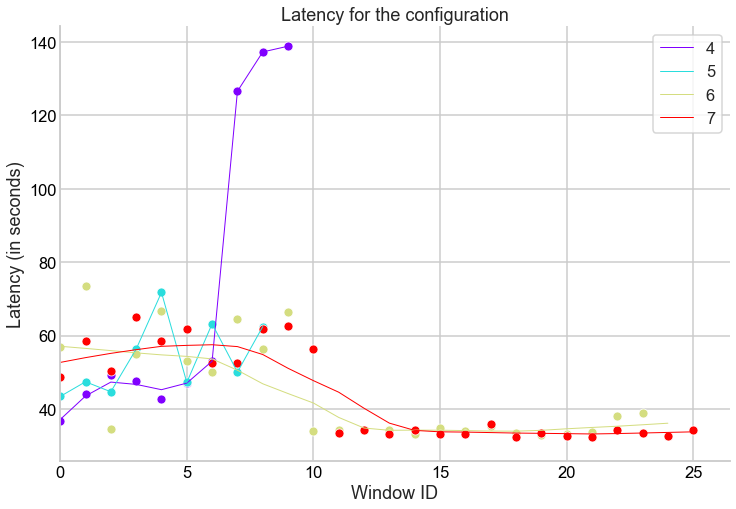

In [11]:
"""
Plot Latency
"""

## Reshape dictionary for visualization and filter out odd values of latency (at the end)
modified_latency = {}
for node_id in config: 
    if config[node_id]['is_worker']:
        modified_latency.update({node_id: []})

for parent_id in latency:
    for window_id in latency[parent_id]:
        for node_id in latency[parent_id][window_id]:
            lag = latency[parent_id][window_id][node_id]
            if lag < base_timestamp:
                modified_latency[node_id].append((window_id, lag))


## Graph colors
plt.figure(figsize=(12, 8))
base_colors = cm.rainbow(np.linspace(0, 1,len(modified_latency))) #For the case of MNIST and one level of heirarchy
colors = dict(list(zip(modified_latency.keys(), base_colors)))

for node_id in modified_latency:
    if len(modified_latency[node_id]) == 0: continue
    [window_ids, lags] = zip(*modified_latency[node_id])
    window_ids, lags = list(window_ids), list(lags)
    
    ## Scatterplot in the background
    ax = sb.scatterplot(window_ids,lags, color=colors[node_id])
    
    ## Smooth fit to the data
    lowess = sm.nonparametric.lowess(lags, window_ids, frac=0.4)
    [lowess_x, lowess_y] = list(zip(*lowess))
    plt.plot(lowess_x, lowess_y, color=colors[node_id], label=node_id)
    
## Axes aesthetics
ax.tick_params(direction='in', length=6, width=2, colors='k', which='major')
ax.tick_params(direction='in', length=4, width=1, colors='r', which='minor')
ax.minorticks_on() 
sb.despine()

plt.title('Latency for the configuration')
plt.xlabel('Window ID')
plt.ylabel('Latency (in seconds)')
plt.xlim(0)
plt.legend()
plt.show()
# plt.clf()


# Model Accuracy for each Node

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


ValueError: x and y arrays must have at least 2 entries

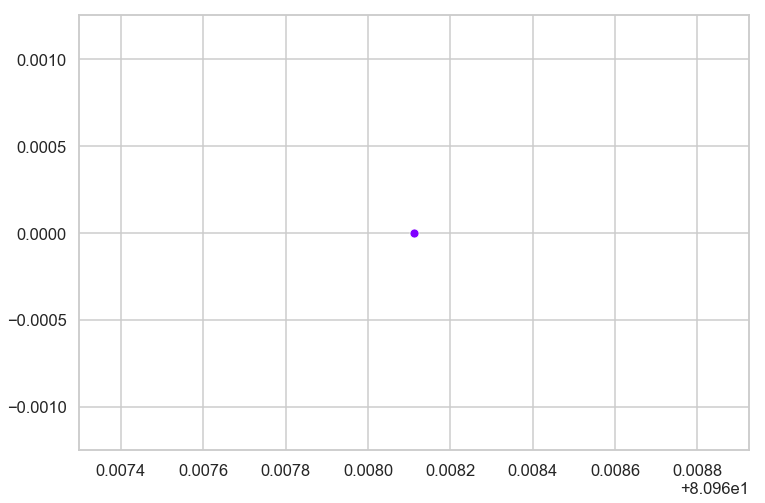

In [12]:
"""
Plot Accuracy
"""

smooth_accuracy = {node_id: {} for node_id in stats}
base_colors = cm.rainbow(np.linspace(0, 1, num_workers))

for node_id, stat in stats.items():
    
    ## Init plot and colormap
    plt.figure(figsize=(12, 8))
    colors = [base_colors[i%num_workers] for i in range(len(stat[ACCURACY]))]
    #colors = cm.Accent(np.linspace(0, 1, len(stat[ACCURACY])))
    
    ## Plotting
    files = OrderedDict(sorted(stat[ACCURACY].items()))    
    for f,c in zip(files,colors):
        
        ## Scatterplot in the background
        ax = sb.scatterplot(np.array(stat[TIMESTAMP]),np.array(stat[ACCURACY][f]),color=c)
        
        ## Smooth fit to the data
        lowess = sm.nonparametric.lowess(np.array(stat[ACCURACY][f]), np.array(stat[TIMESTAMP]), frac=0.4)
        [lowess_x, lowess_y] = list(zip(*lowess))
        plt.plot(lowess_x, lowess_y, color=c, label=f)
        
        smooth_accuracy[node_id][f] = interp1d(lowess_x, lowess_y, bounds_error=False)

    ## Axes aesthetics
    ax.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    ax.tick_params(direction='in', length=4, width=1, colors='r', which='minor')
    ax.minorticks_on() 
    sb.despine()
    
    plt.title('Accuracy plot for Node %d'%node_id)
    plt.xlabel('Seconds')
    plt.ylabel('Accuracy')
    plt.xlim(0)
    plt.ylim(0,100)
    plt.legend(ncol=2, loc='lower right')
    
    plt.show()
    #plt.clf()

# Accuracy Lag for each Node

In [ ]:
"""
Plot Accuracy Lag
"""

accuracy_lag = {query_node: None for query_node in cloud_stats}

for query_node in cloud_stats:
    cl_accuracy, cl_timestamp = cloud_stats[query_node][ACCURACY], cloud_stats[query_node][TIMESTAMP]
    accuracy = { f : smooth_accuracy[query_node][f](cl_timestamp) for f in cl_accuracy }
    accuracy_lag[query_node] = {f : [ cla - a for cla,a in zip(cl_accuracy[f], accuracy[f])] for f in cl_accuracy}

for query_node, lag in accuracy_lag.items():
    
    ## Init plot and colormap
    plt.figure(figsize=(12, 8))
    colors = [base_colors[i%num_workers] for i in range(len(lag))]
    
    cl_timestamp = cloud_stats[query_node][TIMESTAMP]
    ## Plotting
    files = OrderedDict(sorted(lag.items()))    
    for f,c in zip(files,colors):
        
        ## Scatterplot in the background
        ax = sb.scatterplot(np.array(cl_timestamp),np.array(lag[f]),color=c)
        
        ## Smooth fit to the data
        lowess = sm.nonparametric.lowess(np.array(lag[f]), np.array(cl_timestamp), frac=0.4)
        [lowess_x, lowess_y] = list(zip(*lowess))
        plt.plot(lowess_x, lowess_y, color=c, label=f)
        
    ## Axes aesthetics
    ax.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    ax.tick_params(direction='in', length=4, width=1, colors='r', which='minor')
    ax.minorticks_on() 
    sb.despine()
    
    plt.title('Accuracy Lag for Node %d'%query_node)
    plt.xlabel('Seconds')
    plt.ylabel('Accuracy Lag')
    plt.xlim(0)
    plt.ylim(-100,100)
    plt.legend(ncol=2, loc='lower right')
    
    plt.show()
    #plt.clf()